[정리]
  
- 키워드 리스트 추출  
    - 일주일 전(같은 요일) 하루동안 검색으로 노출된 상품 데이터
- 대상 키워드에 대한 통계  
    - 노출수
    - 성별
    - 나이 (연령대 그룹)
    - content position
- 타게팅에 대한 f(x)
    - android/ios
    - 나이 (3살 단위)

In [7]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO


# 키워드 리스트 추출  

In [10]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import date, timedelta

date = date.today() - timedelta(days = 1)
print('Data extracted from ', date)

q = '''
SELECT i.imp_id,
       i.ref_term,
       i.content_position,
       i.device_type,
       u.gender,
       Extract(year FROM Getdate()) - u.birth_year + 1 AS user_age,
       CASE 
           WHEN user_age >= 10 and user_age < 20 then '10~20'
           WHEN user_age >= 20 and user_age < 30 then '20~30'
           WHEN user_age >= 30 and user_age < 40 then '30~40'
           WHEN user_age >= 40 and user_age < 50 then '40~50'
           WHEN user_age >= 50 then '50~'
           ELSE 'none'
        END AS age_group
FROM bun_log_db.app_event_type_impression i
JOIN
  (SELECT ref_term
   FROM bun_log_db.app_event_type_impression
   WHERE ref_term IS NOT NULL
     AND device_type IN ('a')
     AND YEAR||MONTH||DAY = {}
   GROUP BY 1
   ORDER BY count(*) DESC
   LIMIT 10000) t ON i.ref_term = t.ref_term
JOIN service1_quicket.user_identification_v2 u ON i.user_id = u.uid
WHERE i.year||i.month||i.day = {}
  AND i.device_type IN ('a')
  AND page_id = '검색결과'
'''.format('\'' + date.strftime('%Y%m%d') + '\'', '\'' + date.strftime('%Y%m%d') + '\'')

df = pd.read_sql(q, con=bun_dw)

Data extracted from  2020-09-08


In [11]:
df.to_csv('top10k.csv', index=False)

In [12]:
df.shape

(22439235, 7)

# 키워드별 노출 수와 랭킹

In [13]:
keywords_df = df.groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False).reset_index(drop=True)
keywords_df.columns = ['ref_term', 'imp_cnt']

In [14]:
keywords_df.head(10)

,ref_term,imp_cnt
0,아이폰,99720
1,노트북,89122
2,자전거,83231
3,아이즈원,81777
4,나이키,81103
5,픽시,79074
6,스톤아일랜드,75886
7,샤넬,74703
8,오토바이,72454
9,시계,72047


# 디바이스 비율
- 현재 ios의 버그로 android만 뽑음

# 성별 비율
#### 0: none, 1: female, 2: male

In [33]:
age = df.groupby('sex', as_index=False)['imp_id'].agg(lambda x: round(len(x)/len(df), 2))
age.columns = ['sex', 'prob']
age

,sex,prob
0,0,0.00
1,1,0.40
2,2,0.59


# 나이 비율

In [15]:
age_group = df.groupby('age_group', as_index=False)['imp_id'].agg(lambda x: round(len(x)/len(df), 2))
age_group.columns = ['age_group', 'prob']
age_group

,age_group,prob
0,10~20,0.18
1,20~30,0.31
2,30~40,0.20
3,40~50,0.20
4,50~,0.11
5,none,0.00


#### 타게팅 할 경우

{예상 노출 수} = keywords_df[keywords_df['ref_term'
].isin(keywords)]['imp_cnt'].sum() x age[age['sex'] == sex]['prob'] x age_group[age_group['age_group'].isin(ages)]['prob'].sum()

# 키워드별 content position에 대한 노출 수

- content position의 숫자가 커질수록 노출수가 줄어드는 percentage가 양수,음수 왔다갔다함  
- 현재 노출이 3단위로 되어있어서 content position이 3의 배수인 것들만 봤을 때는 대부분 노출수가 줄어드는 Percentage가 양수  
-> 노출 content position이 3의 배수인 것만 보기 (ex. content position 0: rank 1 // content position 3: rank 2) 

In [18]:
df['content_position'] = df['content_position'].astype(int)
keywords = df['ref_term'].unique()
keyword_stat = {}
dt = df[(df['content_position'] <= 15) & (df['content_position'] % 3 == 0)]
for k in keywords:
    temp = one_piece = dt[dt['ref_term'] == k].groupby('content_position', as_index=False)['imp_id'].count().sort_values('content_position')
    temp.columns = ['ref_term', 'imp_cnt']
    dec = []
    for i in range(1, len(temp)):
        dec.append(round((temp.loc[i-1, 'imp_cnt'] - temp.loc[i, 'imp_cnt'])/temp.loc[i-1, 'imp_cnt']*100, 2))
    keyword_stat[k] = dec

In [22]:
keyword_stat

{'125cc': [67.21, 26.67, 9.09, 5.0, 13.16],
 '14k': [63.72, 10.41, 2.83, 2.92, 2.1],
 '14k 목걸이': [65.75, 8.0, 13.04, 10.0, 0.0],
 '14k귀걸이': [67.31, 11.76, 0.0, 0.0, 0.0],
 '14k목걸이': [61.29, 16.67, 5.71, 1.52, 3.08],
 '14k반지': [58.58, 14.29, 6.67, 7.14, 1.92],
 '14k팔찌': [60.39, 4.92, 1.72, 0.0, 1.75],
 '17인치휠': [58.62, 25.0, -11.11, 0.0, 0.0],
 '18k': [62.71, 15.15, 2.38, 1.22, 4.94],
 '18k목걸이': [62.5, 14.81, 0.0, 0.0, 4.35],
 '18k반지': [52.94, 20.83, 2.63, 2.7, 8.33],
 '18k팔찌': [59.89, 12.33, 3.12, 0.0, 4.84],
 '18인치': [66.67, 8.7, 4.76, 10.0, -5.56],
 '18인치 휠': [71.08, 12.5, 4.76, 10.0, 5.56],
 '18인치휠': [64.29, 20.0, 0.0, 6.25, 6.67],
 '19인치': [68.84, 7.46, 8.06, 1.75, 8.93],
 '19인치휠': [57.5, 20.59, 0.0, 0.0, 3.7],
 '2019 메모리즈': [57.14, 25.53, 8.57, 8.33, 6.82],
 '2019메모리즈': [62.35, 13.11, 5.66, 4.0, 6.25],
 '245': [72.17, 12.5, 3.57, 0.0, 3.7],
 '250': [74.64, 34.29, -4.35, 4.17, 0.0],
 '260': [71.11, 5.13, 5.41, 5.71, -3.03],
 '265': [67.65, 9.09, 5.0, 10.53, 2.94],
 '270': [69.33, 1

In [19]:
rank1_2 = []
rank2_3 = []
rank3_4 = []
rank4_5 = []
for i, j in keyword_stat.items():
    if len(j) >= 1:
        rank1_2.append(j[0])
    if len(j) >= 2:
        rank2_3.append(j[1])
    if len(j) >= 3:
        rank3_4.append(j[2])
    if len(j) >= 4:
        rank4_5.append(j[3])

(array([  2.,   0.,   0.,   3.,   5.,  27., 201., 623., 115.,   8.]),
 array([ 0. ,  8.7, 17.4, 26.1, 34.8, 43.5, 52.2, 60.9, 69.6, 78.3, 87. ]),
 <a list of 10 Patch objects>)

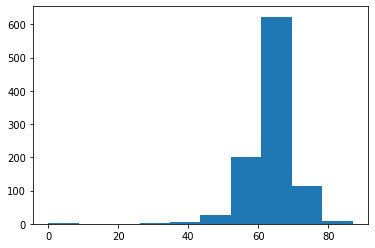

In [30]:
import matplotlib.pyplot as plt

plt.hist([int(i) for i in rank1_2])

(array([  3.,  16., 114., 205., 283., 275.,  64.,  11.,   5.,   6.]),
 array([-16. ,  -8.8,  -1.6,   5.6,  12.8,  20. ,  27.2,  34.4,  41.6,
         48.8,  56. ]),
 <a list of 10 Patch objects>)

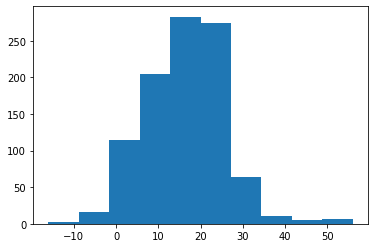

In [31]:
plt.hist([int(i) for i in rank2_3])

In [25]:
import statistics

print('average of imp cnt % decreased from rank 1 to 2:', statistics.mean(rank1_2))
print('average of imp cnt % decreased from rank 2 to 3:', statistics.mean(rank2_3))
print('average of imp cnt % decreased from rank 3 to 4:', statistics.mean(rank3_4))
print('average of imp cnt % decreased from rank 4 to 5:', statistics.mean(rank4_5))

average of imp cnt % decreased from rank 1 to 2: 64.03980691056911
average of imp cnt % decreased from rank 2 to 3: 16.365753564154787
average of imp cnt % decreased from rank 3 to 4: 4.524943934760448
average of imp cnt % decreased from rank 4 to 5: 4.269244897959184


- 평균적으로 content position 0에서의 노출 수에서 3에서의 노출 수는 64% 하락  
- " 3에서 6은 16% 하락  
- " 6에서 9는 4% 하락  
- 그 후로는 비슷